# Convolutional Neural Network (CNN)
In this notebook, we build a multilayer perceptron for digit recognition trained on the MNIST dataset. We used [Deep-Learning-Experiments](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/versions/2022/mlp/python/mlp_pytorch_demo.ipynb) and [In Depth Explanation | Convolutional Neural Networks | From Scratch](https://www.youtube.com/watch?v=jDe5BAsT2-Y) as reference.

In [1]:
# Import necessary libraries
import os
import torch
from torch import nn
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import Accuracy
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from argparse import ArgumentParser
from PIL import Image
from matplotlib import pyplot as plt

c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


We create a simple 2-layer convolutional neural network for digit recognition. We use torch.nn.Module as superclass to remove boilerplate code. Unlike the nn.Linear used in the [MLP Notebook](https://github.com/davidpiscasio/deep-learning/blob/main/MLP/mlp.ipynb), the number of input features in nn.Conv2d corresponds to the number of channels in the input image, thus we have num_features = 1 since we are using the MNIST dataset.

In [13]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, num_features=1, num_filters=8, num_classes=10):
        super().__init__()
        
        # Build the first layer of the CNN
        self.conv0 = nn.Conv2d(in_channels=num_features, out_channels=num_filters, kernel_size=5)
        self.relu = nn.ReLU()

        # Build the second layer of the CNN
        self.conv1 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters*4, kernel_size=3)
        self.sigmoid = nn.Sigmoid()

        # Setup Max Pooling and Fully Connected (FC) Layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(in_features=32*5*5, out_features=num_classes)

    def forward(self, x):
        # First Convolutional Layer
        y = self.conv0(x)
        y = self.relu(y)
        y = self.maxpool(y)

        # Second Convolutional Layer
        y = self.conv1(y)
        y = self.sigmoid(y)
        y = self.maxpool(y)

        # Third FC Layer
        y = torch.flatten(y, 1)
        y = self.fc(y)

        return y

*Note: In getting the number of in_features for the fc layer, we can determine this by extracting the output shape of each layer for a random tensor.*

In [12]:
num_features=1
num_filters=8
num_classes=10

conv0 = nn.Conv2d(in_channels=num_features, out_channels=num_filters, kernel_size=5)
relu = nn.ReLU()
conv1 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters*4, kernel_size=3)
sigmoid = nn.Sigmoid()
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
fc = nn.Linear(in_features=32*5*5, out_features=num_classes)

x = torch.randn(5,1,28,28) # Shape: B(atch) = 5, C(hannels) = 1, H(eight) = 28, W(idth) = 28
y = relu(conv0(x))
print(f'Conv 0 shape: {y.shape[1:]}')
y = maxpool(y)
print(f'Maxpool 0 shape: {y.shape[1:]}')
y = sigmoid(conv1(y))
print(f'Conv 1 shape: {y.shape[1:]}')
y = maxpool(y)
print(f'Maxpool 0 shape: {y.shape[1:]}') # The shape of the final convolutional layer's output
y = torch.flatten(y,1)
print(f'FC in_features shape: {y.shape[1:]}') # The shape of the flattened input to the FC layer (which is the in_features on the fc layer).
y = fc(y)
print(f'Final layer shape: {y.shape[1:]}')

Conv 0 shape: torch.Size([8, 24, 24])
Maxpool 0 shape: torch.Size([8, 12, 12])
Conv 1 shape: torch.Size([32, 10, 10])
Maxpool 0 shape: torch.Size([32, 5, 5])
FC in_features shape: torch.Size([800])
Final layer shape: torch.Size([10])


We now perform the necessary preparations for the dataset and training, using the PyTorch Lightning module.

In [14]:
class MNISTCNNModel(pl.LightningModule):
    def __init__(self, lr=0.001, batch_size=64, num_workers=1, max_epochs=30, model=ConvolutionalNeuralNetwork, optim="adam"):
        # Initiate LightningModule superclass
        super().__init__()
        self.train_step_outputs = []
        self.test_step_outputs = []

        # Set up other parameters
        self.save_hyperparameters()
        self.model = model()

        # Set up loss function (Mean Squared Error) and accuracy
        self.loss = nn.MSELoss()
        #self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=10)
        self.optim = optim 

    def forward(self,x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        # Perform one-hot encoding on y first
        y = self.mnist_one_hot(y) # Comment if using CrossEntropyLoss()
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.train_step_outputs.append({"loss": loss})
        return loss
    
    def on_train_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.train_step_outputs]).mean()
        print(f'Train loss: {avg_loss}')
        self.train_step_outputs.clear()
        self.log("train_loss", avg_loss, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        # Perform one-hot encoding on y first. We keep the original y for the accuracy
        y_oh = self.mnist_one_hot(y) # Comment if using CrossEntropyLoss()
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y_oh) # Comment if using CrossEntropyLoss()
        #loss = self.loss(y_hat, y) # Uncomment if using CrossEntropyLoss()
        # We get the predictions through argmax
        y_preds = torch.argmax(y_hat, dim=1)
        acc = self.accuracy(y, y_preds) * 100. # Comment if using CrossEntropyLoss()
        #acc = self.accuracy(y, y_hat) * 100. # Uncomment if using CrossEntropyLoss()
        self.test_step_outputs.append({"y_hat": y_hat, "test_loss": loss, "test_acc": acc})
        return y_hat, loss, acc
    
    def on_test_epoch_end(self):
        avg_loss = torch.stack([x["test_loss"] for x in self.test_step_outputs]).mean()
        avg_acc = torch.stack([x["test_acc"] for x in self.test_step_outputs]).mean()
        print(f'Test loss: {avg_loss}')
        print(f'Test accuracy: {avg_acc}')
        self.test_step_outputs.clear()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", avg_acc, on_epoch=True, prog_bar=True)

    def validation_step(self, batch, batch_idx):
       return self.test_step(batch, batch_idx)

    def on_validation_epoch_end(self):
        return self.on_test_epoch_end()
    
    def configure_optimizers(self):
        if self.optim == "adam":
            optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        elif self.optim == "sgd":
            optimizer = SGD(self.parameters(), lr=self.hparams.lr)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler]
    
    # Settings from https://nextjournal.com/gkoehler/pytorch-mnist
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.MNIST('/files/', train=True, download=True,
                                        transform=torchvision.transforms.ToTensor()), 
                                        batch_size=self.hparams.batch_size, shuffle=True, pin_memory=True)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.MNIST('/files/', train=False, download=True,
                                        transform=torchvision.transforms.ToTensor()), 
                                        batch_size=self.hparams.batch_size, shuffle=False, pin_memory=True)
    
    def val_dataloader(self):
        return self.test_dataloader()
    
    def setup(self, stage=None):
        self.train_dataloader()
        self.test_dataloader()

    # Perform MNIST-specific one-hot encoding
    def mnist_one_hot(self, x):
        device = 'cuda' if 'cuda' in str(x.device) else 'cpu'
        y_oh = torch.zeros(size=(x.shape[0],10), device=device)
        y_oh.to(device)
        for i, y in enumerate(x):
            y_oh[i,y] = 1
        return y_oh.float()

After setting up the model, the datasets, and the train/test/validation configurations, we set up the arguments.

In [15]:
def get_args():
    parser = ArgumentParser(description="PyTorch Lightning MNIST Example")
    parser.add_argument("--epochs", type=int, default=30, help="num epochs")
    parser.add_argument("--batch-size", type=int, default=64, help="batch size")
    parser.add_argument("--lr", type=float, default=0.001, help="learning rate")

    parser.add_argument("--num-classes", type=int, default=10, help="num classes")

    parser.add_argument("--optim", default="adam", help="optimizer")
    # Verify device count with torch.cuda.device_count()
    parser.add_argument("--devices", default=1)
    # Verify CUDA availability with torch.cuda.is_available())
    parser.add_argument("--accelerator", default='gpu')
    # Recommended: num_workers = (os.cpu_count() // 2) // torch.cuda.device_count()
    parser.add_argument("--num-workers", type=int, default=4, help="num workers")

    parser.add_argument("--model", default=ConvolutionalNeuralNetwork)
    parser.add_argument("--path", default="models", help="Model save path")
    args = parser.parse_args("")
    return args

Now, we train the CNN model with the MNIST dataset

In [17]:
if __name__ == "__main__":
    args = get_args()
    model = MNISTCNNModel(lr=args.lr, batch_size=args.batch_size,
                           num_workers=args.num_workers,
                           model=args.model, optim=args.optim)
    model.setup()
    print(model)

    model_checkpoint = ModelCheckpoint(
        dirpath=os.path.join(args.path, "checkpoints"),
        filename="mnist-cnn-best-acc",
        save_top_k=1,
        verbose=True,
        monitor='test_acc',
        mode='max')

    trainer = pl.Trainer(accelerator=args.accelerator,
                      devices=args.devices,
                      max_epochs=args.epochs,
                      callbacks=model_checkpoint)

    trainer.fit(model)
    trainer.test(model)

    model = model.load_from_checkpoint(os.path.join(args.path, "checkpoints", "mnist-cnn-best-acc.ckpt"))
    model.eval()
    script = model.to_torchscript()
    model_path = os.path.join(args.path, "checkpoints", "mnist-cnn-best-acc.pt")
    torch.jit.save(script, model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                       | Params
--------------------------------------------------------
0 | model    | ConvolutionalNeuralNetwork | 10.6 K
1 | loss     | MSELoss                    | 0     
2 | accuracy | MulticlassAccuracy         | 0     
--------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)


MNISTCNNModel(
  (model): ConvolutionalNeuralNetwork(
    (conv0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU()
    (conv1): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
    (sigmoid): Sigmoid()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Linear(in_features=800, out_features=10, bias=True)
  )
  (loss): MSELoss()
  (accuracy): MulticlassAccuracy()
)
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 22.92it/s]Test loss: 0.16768120229244232
Test accuracy: 7.8125
Epoch 17:  36%|███▌      | 340/938 [00:55<01:37,  6.10it/s, v_num=1, test_loss=0.00982, test_acc=98.20]
Test loss: 0.020152080804109573
Test accuracy: 95.7304916381836
Epoch 0: 100%|██████████| 938/938 [00:19<00:00, 47.12it/s, v_num=2, test_loss=0.0202, test_acc=95.70]

Epoch 0, global step 938: 'test_acc' reached 95.73049 (best 95.73049), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\CNN\\models\\checkpoints\\mnist-cnn-best-acc.ckpt' as top 1


Train loss: 0.039070263504981995
Epoch 1: 100%|██████████| 938/938 [00:17<00:00, 53.29it/s, v_num=2, test_loss=0.0202, test_acc=95.70]Test loss: 0.016158465296030045
Test accuracy: 97.23328399658203
Epoch 1: 100%|██████████| 938/938 [00:21<00:00, 44.53it/s, v_num=2, test_loss=0.0162, test_acc=97.20]Train loss: 0.01832578517496586


Epoch 1, global step 1876: 'test_acc' reached 97.23328 (best 97.23328), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\CNN\\models\\checkpoints\\mnist-cnn-best-acc.ckpt' as top 1


Epoch 2: 100%|██████████| 938/938 [00:17<00:00, 53.61it/s, v_num=2, test_loss=0.0162, test_acc=97.20]Test loss: 0.014158506877720356
Test accuracy: 97.60151672363281
Epoch 2: 100%|██████████| 938/938 [00:20<00:00, 46.82it/s, v_num=2, test_loss=0.0142, test_acc=97.60]

Epoch 2, global step 2814: 'test_acc' reached 97.60152 (best 97.60152), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\CNN\\models\\checkpoints\\mnist-cnn-best-acc.ckpt' as top 1


Train loss: 0.01542994286864996
Epoch 3: 100%|██████████| 938/938 [00:18<00:00, 50.20it/s, v_num=2, test_loss=0.0142, test_acc=97.60]Test loss: 0.013767528347671032
Test accuracy: 97.6811294555664
Epoch 3: 100%|██████████| 938/938 [00:22<00:00, 42.59it/s, v_num=2, test_loss=0.0138, test_acc=97.70]Train loss: 0.014053884893655777


Epoch 3, global step 3752: 'test_acc' reached 97.68113 (best 97.68113), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\CNN\\models\\checkpoints\\mnist-cnn-best-acc.ckpt' as top 1


Epoch 4: 100%|██████████| 938/938 [00:17<00:00, 53.18it/s, v_num=2, test_loss=0.0138, test_acc=97.70]Test loss: 0.012414338998496532
Test accuracy: 97.90007781982422
Epoch 4: 100%|██████████| 938/938 [00:20<00:00, 46.39it/s, v_num=2, test_loss=0.0124, test_acc=97.90]Train loss: 0.013168871402740479


Epoch 4, global step 4690: 'test_acc' reached 97.90008 (best 97.90008), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\CNN\\models\\checkpoints\\mnist-cnn-best-acc.ckpt' as top 1


Epoch 5: 100%|██████████| 938/938 [00:18<00:00, 50.86it/s, v_num=2, test_loss=0.0124, test_acc=97.90]Test loss: 0.0119793601334095
Test accuracy: 98.08917236328125
Epoch 5: 100%|██████████| 938/938 [00:21<00:00, 42.84it/s, v_num=2, test_loss=0.012, test_acc=98.10] 

Epoch 5, global step 5628: 'test_acc' reached 98.08917 (best 98.08917), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\CNN\\models\\checkpoints\\mnist-cnn-best-acc.ckpt' as top 1


Train loss: 0.012579728849232197
Epoch 6: 100%|██████████| 938/938 [00:18<00:00, 49.90it/s, v_num=2, test_loss=0.012, test_acc=98.10]Test loss: 0.011760151945054531
Test accuracy: 98.21855163574219
Epoch 6: 100%|██████████| 938/938 [00:21<00:00, 42.96it/s, v_num=2, test_loss=0.0118, test_acc=98.20]

Epoch 6, global step 6566: 'test_acc' reached 98.21855 (best 98.21855), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\CNN\\models\\checkpoints\\mnist-cnn-best-acc.ckpt' as top 1


Train loss: 0.012193304486572742
Epoch 7: 100%|██████████| 938/938 [00:19<00:00, 49.10it/s, v_num=2, test_loss=0.0118, test_acc=98.20]Test loss: 0.011530122719705105
Test accuracy: 98.30812072753906
Epoch 7: 100%|██████████| 938/938 [00:22<00:00, 41.05it/s, v_num=2, test_loss=0.0115, test_acc=98.30]

Epoch 7, global step 7504: 'test_acc' reached 98.30812 (best 98.30812), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\CNN\\models\\checkpoints\\mnist-cnn-best-acc.ckpt' as top 1


Train loss: 0.011801959946751595
Epoch 8: 100%|██████████| 938/938 [00:17<00:00, 52.31it/s, v_num=2, test_loss=0.0115, test_acc=98.30]Test loss: 0.011290260590612888
Test accuracy: 98.31807708740234
Epoch 8: 100%|██████████| 938/938 [00:20<00:00, 44.78it/s, v_num=2, test_loss=0.0113, test_acc=98.30]

Epoch 8, global step 8442: 'test_acc' reached 98.31808 (best 98.31808), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\CNN\\models\\checkpoints\\mnist-cnn-best-acc.ckpt' as top 1


Train loss: 0.01148711796849966
Epoch 9: 100%|██████████| 938/938 [00:18<00:00, 50.40it/s, v_num=2, test_loss=0.0113, test_acc=98.30]Test loss: 0.011996748857200146
Test accuracy: 98.20860290527344
Epoch 9: 100%|██████████| 938/938 [00:22<00:00, 42.62it/s, v_num=2, test_loss=0.012, test_acc=98.20] 

Epoch 9, global step 9380: 'test_acc' was not in top 1


Train loss: 0.011228312738239765
Epoch 10: 100%|██████████| 938/938 [00:18<00:00, 51.16it/s, v_num=2, test_loss=0.012, test_acc=98.20]Test loss: 0.01061130128800869
Test accuracy: 98.38774108886719
Epoch 10: 100%|██████████| 938/938 [00:22<00:00, 42.62it/s, v_num=2, test_loss=0.0106, test_acc=98.40]Train loss: 0.011003797873854637


Epoch 10, global step 10318: 'test_acc' reached 98.38774 (best 98.38774), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\CNN\\models\\checkpoints\\mnist-cnn-best-acc.ckpt' as top 1


Epoch 11: 100%|██████████| 938/938 [00:18<00:00, 51.35it/s, v_num=2, test_loss=0.0106, test_acc=98.40]Test loss: 0.011097626760601997
Test accuracy: 98.36783599853516
Epoch 11: 100%|██████████| 938/938 [00:20<00:00, 44.76it/s, v_num=2, test_loss=0.0111, test_acc=98.40]Train loss: 0.010770335793495178


Epoch 11, global step 11256: 'test_acc' was not in top 1


Epoch 12: 100%|██████████| 938/938 [00:18<00:00, 51.19it/s, v_num=2, test_loss=0.0111, test_acc=98.40]Test loss: 0.010473229922354221
Test accuracy: 98.5469741821289
Epoch 12: 100%|██████████| 938/938 [00:21<00:00, 43.06it/s, v_num=2, test_loss=0.0105, test_acc=98.50]Train loss: 0.010568228550255299


Epoch 12, global step 12194: 'test_acc' reached 98.54697 (best 98.54697), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\CNN\\models\\checkpoints\\mnist-cnn-best-acc.ckpt' as top 1


Epoch 13: 100%|██████████| 938/938 [00:17<00:00, 52.64it/s, v_num=2, test_loss=0.0105, test_acc=98.50]Test loss: 0.010486982762813568
Test accuracy: 98.3777847290039
Epoch 13: 100%|██████████| 938/938 [00:21<00:00, 43.74it/s, v_num=2, test_loss=0.0105, test_acc=98.40]Train loss: 0.010375550016760826


Epoch 13, global step 13132: 'test_acc' was not in top 1


Epoch 14: 100%|██████████| 938/938 [00:18<00:00, 52.08it/s, v_num=2, test_loss=0.0105, test_acc=98.40]Test loss: 0.010066232644021511
Test accuracy: 98.4972152709961
Epoch 14: 100%|██████████| 938/938 [00:21<00:00, 44.42it/s, v_num=2, test_loss=0.0101, test_acc=98.50]

Epoch 14, global step 14070: 'test_acc' was not in top 1


Train loss: 0.010233045555651188
Epoch 15: 100%|██████████| 938/938 [00:17<00:00, 53.30it/s, v_num=2, test_loss=0.0101, test_acc=98.50]Test loss: 0.009771609678864479
Test accuracy: 98.42755126953125
Epoch 15: 100%|██████████| 938/938 [00:20<00:00, 45.03it/s, v_num=2, test_loss=0.00977, test_acc=98.40]Train loss: 0.010064171627163887

Epoch 15, global step 15008: 'test_acc' was not in top 1



Epoch 16: 100%|██████████| 938/938 [00:18<00:00, 51.96it/s, v_num=2, test_loss=0.00977, test_acc=98.40]Test loss: 0.009635714814066887
Test accuracy: 98.4972152709961
Epoch 16: 100%|██████████| 938/938 [00:21<00:00, 43.59it/s, v_num=2, test_loss=0.00964, test_acc=98.50]

Epoch 16, global step 15946: 'test_acc' was not in top 1


Train loss: 0.009916639886796474
Epoch 17: 100%|██████████| 938/938 [00:17<00:00, 52.86it/s, v_num=2, test_loss=0.00964, test_acc=98.50]Test loss: 0.009781239554286003
Test accuracy: 98.46736145019531
Epoch 17: 100%|██████████| 938/938 [00:20<00:00, 45.75it/s, v_num=2, test_loss=0.00978, test_acc=98.50]Train loss: 0.009809404611587524


Epoch 17, global step 16884: 'test_acc' was not in top 1


Epoch 18: 100%|██████████| 938/938 [00:17<00:00, 53.23it/s, v_num=2, test_loss=0.00978, test_acc=98.50]Test loss: 0.00957544893026352
Test accuracy: 98.46736145019531
Epoch 18: 100%|██████████| 938/938 [00:21<00:00, 44.60it/s, v_num=2, test_loss=0.00958, test_acc=98.50]Train loss: 0.009665667079389095


Epoch 18, global step 17822: 'test_acc' was not in top 1


Epoch 19: 100%|██████████| 938/938 [00:18<00:00, 51.00it/s, v_num=2, test_loss=0.00958, test_acc=98.50]Test loss: 0.009662560187280178
Test accuracy: 98.53702545166016
Epoch 19: 100%|██████████| 938/938 [00:21<00:00, 43.78it/s, v_num=2, test_loss=0.00966, test_acc=98.50]Train loss: 0.009566543623805046


Epoch 19, global step 18760: 'test_acc' was not in top 1


Epoch 20: 100%|██████████| 938/938 [00:17<00:00, 52.87it/s, v_num=2, test_loss=0.00966, test_acc=98.50]Test loss: 0.009288799948990345
Test accuracy: 98.47731018066406
Epoch 20: 100%|██████████| 938/938 [00:21<00:00, 44.64it/s, v_num=2, test_loss=0.00929, test_acc=98.50]

Epoch 20, global step 19698: 'test_acc' was not in top 1


Train loss: 0.009509210474789143
Epoch 21: 100%|██████████| 938/938 [00:17<00:00, 53.03it/s, v_num=2, test_loss=0.00929, test_acc=98.50]Test loss: 0.009281237609684467
Test accuracy: 98.52706909179688
Epoch 21: 100%|██████████| 938/938 [00:21<00:00, 44.60it/s, v_num=2, test_loss=0.00928, test_acc=98.50]

Epoch 21, global step 20636: 'test_acc' was not in top 1


Train loss: 0.009390388615429401
Epoch 22: 100%|██████████| 938/938 [00:18<00:00, 51.99it/s, v_num=2, test_loss=0.00928, test_acc=98.50]Test loss: 0.009289386682212353
Test accuracy: 98.46736145019531
Epoch 22: 100%|██████████| 938/938 [00:21<00:00, 43.59it/s, v_num=2, test_loss=0.00929, test_acc=98.50]

Epoch 22, global step 21574: 'test_acc' was not in top 1


Train loss: 0.009313440881669521
Epoch 23: 100%|██████████| 938/938 [00:18<00:00, 51.85it/s, v_num=2, test_loss=0.00929, test_acc=98.50]Test loss: 0.009247680194675922
Test accuracy: 98.48725891113281
Epoch 23: 100%|██████████| 938/938 [00:21<00:00, 43.82it/s, v_num=2, test_loss=0.00925, test_acc=98.50]Train loss: 0.009251008741557598

Epoch 23, global step 22512: 'test_acc' was not in top 1



Epoch 24: 100%|██████████| 938/938 [00:18<00:00, 52.11it/s, v_num=2, test_loss=0.00925, test_acc=98.50]Test loss: 0.00921054370701313
Test accuracy: 98.50716400146484
Epoch 24: 100%|██████████| 938/938 [00:21<00:00, 43.76it/s, v_num=2, test_loss=0.00921, test_acc=98.50]Train loss: 0.009185400791466236


Epoch 24, global step 23450: 'test_acc' was not in top 1


Epoch 25: 100%|██████████| 938/938 [00:18<00:00, 51.73it/s, v_num=2, test_loss=0.00921, test_acc=98.50]Test loss: 0.009141163900494576
Test accuracy: 98.5469741821289
Epoch 25: 100%|██████████| 938/938 [00:21<00:00, 43.44it/s, v_num=2, test_loss=0.00914, test_acc=98.50]Train loss: 0.009132733568549156


Epoch 25, global step 24388: 'test_acc' was not in top 1


Epoch 26: 100%|██████████| 938/938 [00:18<00:00, 52.04it/s, v_num=2, test_loss=0.00914, test_acc=98.50]Test loss: 0.0090885479003191
Test accuracy: 98.50716400146484
Epoch 26: 100%|██████████| 938/938 [00:21<00:00, 43.84it/s, v_num=2, test_loss=0.00909, test_acc=98.50]Train loss: 0.00908740796148777


Epoch 26, global step 25326: 'test_acc' was not in top 1


Epoch 27: 100%|██████████| 938/938 [00:18<00:00, 51.91it/s, v_num=2, test_loss=0.00909, test_acc=98.50]Test loss: 0.009089400060474873
Test accuracy: 98.4972152709961
Epoch 27: 100%|██████████| 938/938 [00:21<00:00, 43.69it/s, v_num=2, test_loss=0.00909, test_acc=98.50]Train loss: 0.00905004795640707


Epoch 27, global step 26264: 'test_acc' was not in top 1


Epoch 28: 100%|██████████| 938/938 [00:17<00:00, 53.72it/s, v_num=2, test_loss=0.00909, test_acc=98.50]Test loss: 0.009042504243552685
Test accuracy: 98.50716400146484
Epoch 28: 100%|██████████| 938/938 [00:20<00:00, 44.80it/s, v_num=2, test_loss=0.00904, test_acc=98.50]Train loss: 0.009023920632898808


Epoch 28, global step 27202: 'test_acc' was not in top 1


Epoch 29: 100%|██████████| 938/938 [00:18<00:00, 51.83it/s, v_num=2, test_loss=0.00904, test_acc=98.50]Test loss: 0.00903730932623148
Test accuracy: 98.50716400146484
Epoch 29: 100%|██████████| 938/938 [00:21<00:00, 43.52it/s, v_num=2, test_loss=0.00904, test_acc=98.50]

Epoch 29, global step 28140: 'test_acc' was not in top 1


Train loss: 0.0090078916400671


`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 938/938 [00:21<00:00, 43.49it/s, v_num=2, test_loss=0.00904, test_acc=98.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 52.90it/s]Test loss: 0.00903730932623148
Test accuracy: 98.50716400146484
Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 52.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             98.50716400146484
        test_loss           0.00903730932623148
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### Notes
* The CNN model only has $10.6k$ parameters and has an estimated model parameter size of $42 kB$, compared to the [MLP Model](https://github.com/davidpiscasio/deep-learning/blob/main/MLP/mlp.ipynb) that has $269k$ parameters and an estimated model parameter size of $1.077 MB$.
* Even with such a large difference in model size, the CNN model still performs slightly better with a test accuracy of $98.50\%$ compared to the MLP model's test accuracy of $98.49\%$. This shows the strength of CNNs in computer vision (CV) applications.

#### Inference of the trained model on handwritten digits
Now that we have successfully trained and saved the model, we use the model for inference on handwritten digits. We have observed that the model failed to predict the digit $8$ correctly and mistook it as a $6$.

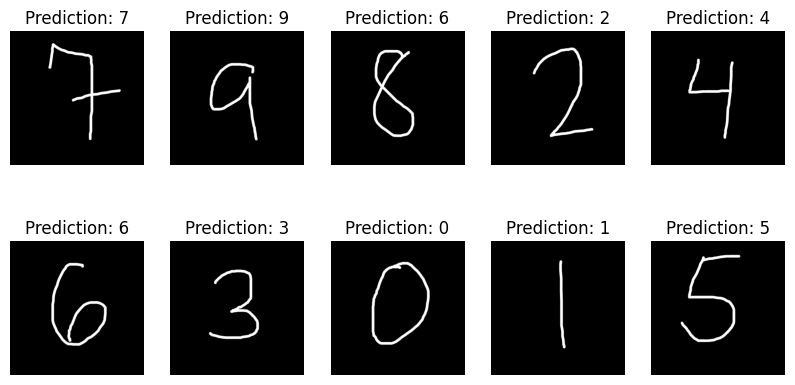

In [21]:
scripted_module = torch.jit.load('models/checkpoints/mnist-cnn-best-acc.pt')
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((28,28)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Grayscale(num_output_channels=1)])

# create figure
fig = plt.figure(figsize=(10, 5))
  
# setting values to rows and column variables
rows = 2
columns = 5

imgs = [Image.open('digits/digit0.png'), 
        Image.open('digits/digit1.png'),
        Image.open('digits/digit2.png'),
        Image.open('digits/digit3.png'),
        Image.open('digits/digit4.png'),
        Image.open('digits/digit5.png'),
        Image.open('digits/digit6.png'),
        Image.open('digits/digit7.png'),
        Image.open('digits/digit8.png'),
        Image.open('digits/digit9.png')]

for i, img in enumerate(imgs):
    img = img.convert('RGB')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    img = transform(img)
    img = torch.unsqueeze(img,0)
    img = img.to('cuda')
    y_hat = scripted_module(img)
    y_pred = torch.argmax(y_hat, dim=1)[0]
    plt.title(f"Prediction: {y_pred}")

If we make the pen thicker, we see that the model now correctly predicts the digit $8$. However, it has made an incorrect prediction for $7$.

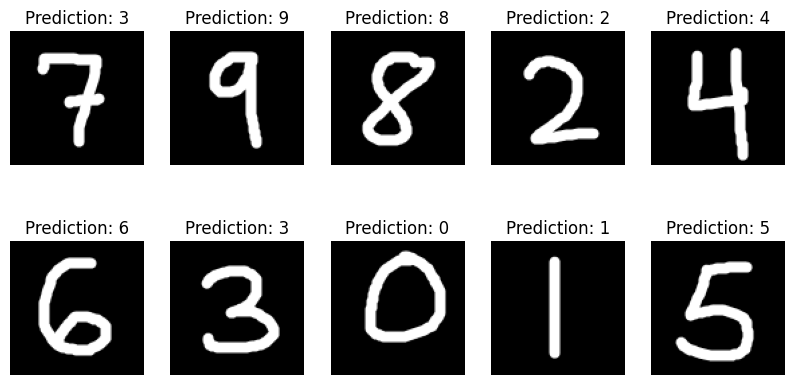

In [22]:
# create figure
fig = plt.figure(figsize=(10, 5))
  
# setting values to rows and column variables
rows = 2
columns = 5

imgs = [Image.open('digits/digit10.png'), 
        Image.open('digits/digit11.png'),
        Image.open('digits/digit12.png'),
        Image.open('digits/digit13.png'),
        Image.open('digits/digit14.png'),
        Image.open('digits/digit15.png'),
        Image.open('digits/digit16.png'),
        Image.open('digits/digit17.png'),
        Image.open('digits/digit18.png'),
        Image.open('digits/digit19.png')]
        
for i, img in enumerate(imgs):
    img = img.convert('RGB')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    img = transform(img)
    img = torch.unsqueeze(img,0)
    img = img.to('cuda')
    y_hat = scripted_module(img)
    y_pred = torch.argmax(y_hat, dim=1)[0]
    plt.title(f"Prediction: {y_pred}")